In [205]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import tensorflow as tf
import tensorflow.keras.backend as kb
tfd = tfp.distributions

seed = 1
np.random.seed(seed)

plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['figure.dpi'] = 80

In [206]:
# def A_i_j(x, y, K, g):    
#     with tf.GradientTape() as tape:
#         # x, y shape: (n_y,dim)
#         tape.watch(x)
#         tape.watch(y)
#         z = K.apply(x,y) # (n_y,)
#         print('kernel: {}'.format(z))
#         dzdx, dzdy = tape.gradient(z, [x,y]) # (n_y,2) (n_y,2)
#     # print('gradient shape: {}'.format(dzdx.shape))
#     # print((dzdx*tf.transpose(tf.convert_to_tensor(g(x), dtype=tf.float32))).shape)
#     vfx = tf.math.reduce_sum(dzdx*tf.transpose(tf.convert_to_tensor(g(x), dtype=tf.float32)),axis=1) # (n_y,)
#     vfy = tf.math.reduce_sum(dzdy*tf.transpose(tf.convert_to_tensor(g(y), dtype=tf.float32)),axis=1) # (n_y,)
#     print('vfx shape: {}'.format(vfx))
#     print('vfy shape: {}'.format(vfy))
#     X, Y = np.meshgrid(vfx, vfy)
#     s = X.shape
    

#     product = tf.tensordot(vfx, vfy, axes=0) # (n_y, n_y)
#     # make sure it is invertible
#     product = product #+ tf.eye(product.shape[0])#* 10e-6
#     return product

In [207]:
def A(xs, ys, K, g):
    matrix_A = np.empty((xs.shape[0], ys.shape[0]))

    for ind, i in enumerate(xs):
        x = tf.repeat([i], repeats=[ys.shape[0]], axis=0)
        with tf.GradientTape() as tape:
            tape.watch(x)
            tape.watch(ys)
            z = K.apply(x,ys) # (n_y,)
        dzdx, dzdy = tape.gradient(z, [x,ys]) # (n_y,2) (n_y,2)
        vfx = tf.math.reduce_sum(dzdx*tf.transpose(tf.convert_to_tensor(g(x), dtype=tf.float32)),axis=1) # (n_y,)
        vfy = tf.math.reduce_sum(dzdy*tf.transpose(tf.convert_to_tensor(g(ys), dtype=tf.float32)),axis=1) # (n_y,)
        a_j = vfx *vfy

        matrix_A[ind] = a_j    

    return matrix_A

In [208]:
def A_trial(xs, ys, K, g):
    matrix_A = np.empty((xs.shape[0], ys.shape[0]))

    for ind, i in enumerate(xs):
        i = i[tf.newaxis, ...]
        for inx, j in enumerate(ys):
            j = j[tf.newaxis, ...]
            # print(i)
            with tf.GradientTape() as tape:
                tape.watch(i)
                tape.watch(j)
                z = K.apply(i,j) # (n_y,)
            dzdx, dzdy = tape.gradient(z, [i,j]) # (n_y,2) (n_y,2)
            g_x = tf.transpose(tf.convert_to_tensor(g(i), dtype=tf.float32))
            g_y = tf.transpose(tf.convert_to_tensor(g(j), dtype=tf.float32))
            inner_product_1 = tf.reduce_sum(dzdx * g_x)
            inner_product_2 = tf.reduce_sum(dzdy * g_y)

            a_j = inner_product_1 * inner_product_2

            matrix_A[ind, inx] = a_j    

    return matrix_A

In [209]:
def build_kernel_matrix(num_datapoints, input_datapoints, kernel_fn, input_rhs):
    """
    Constructs the full kernel matrix element by element
    :return: tf.Tensor, (num_points, num_points)
    """
    kernel_mat = tf.Variable(tf.zeros((num_datapoints, num_datapoints), dtype=tf.float32))

    for i in range(num_datapoints):
        for j in range(i, num_datapoints):
            inputs_i = tf.expand_dims(tf.constant(input_datapoints[i]), 0)  # (1, d)
            inputs_j = tf.expand_dims(tf.constant(input_datapoints[j]), 0)  # (1, d)
            with tf.GradientTape() as tape1:
                tape1.watch(inputs_i)
                with tf.GradientTape() as tape2:
                    tape2.watch(inputs_j)
                    kernel_output = kernel_fn.apply(tf.expand_dims(inputs_i, 0), tf.expand_dims(inputs_j, 0))  # (1, 1, 1)
                    kernel_output = tf.squeeze(kernel_output)  # scalar
                grads2 = tape2.gradient(kernel_output, inputs_j)  # (d,)
                first_inner_product = tf.reduce_sum(grads2 * input_rhs[j])  # scalar
            grads1 = tape1.gradient(first_inner_product, inputs_i)  # (d,)
            second_inner_product = tf.reduce_sum(grads1 * input_rhs[i])  # scalar
            kernel_mat[i, j].assign(second_inner_product)
            if i != j:
                kernel_mat[j, i].assign(second_inner_product)
    K = tf.constant(kernel_mat.numpy())
    return K


In [210]:
def build_lyapunov_function(x, a, num_datapoints, input_datapoints, kernel_fn, input_rhs):
    all_s = tf.Variable(tf.zeros((num_datapoints,), dtype=tf.float32))
    for i in range(num_datapoints):
        inputs_i = tf.expand_dims(tf.constant(input_datapoints[i]), 0)  # (1, d)
        with tf.GradientTape() as tape:
            tape.watch(inputs_i)
            kernel_output = kernel_fn.apply(tf.expand_dims(x, 0), tf.expand_dims(inputs_i, 0))  # (1, 1, 1)
            kernel_output = tf.squeeze(kernel_output)  # scalar
        grads = tape.gradient(kernel_output, inputs_i)  # (d,)
        inner_product = tf.reduce_sum(grads * input_rhs[i])
        all_s[i].assign(inner_product)
    
    s = tf.reduce_sum(all_s* a)
    return s


In [211]:
# from numpy import inner


def get_s(x, y, K, g, a = None):
    # y: (n_y, d)
    x = tf.repeat(x, repeats=[y.shape[0]], axis=0)
    # print('x: {}'.format(x.shape))
    with tf.GradientTape() as tape:
        tape.watch(y)
        kernel = K.apply(x,y) # (n_y,) 
    grad = tape.gradient(kernel,y) # (n_y, dim)
        # print(grad)
    # inner_product = kb.sum(grad*kb.transpose(tf.convert_to_tensor(g(y), dtype=tf.float32)),axis=0)[..., tf.newaxis] # (dim, 1)
    # (n_y, 1)
    inner_product = tf.math.reduce_sum(grad*kb.transpose(tf.convert_to_tensor(g(y), dtype=tf.float32)),axis=1)[..., tf.newaxis]
    # print(inner_product)
    # print(inner_product.shape)
    # s = tf.tensordot(a, inner_product, axes=1)
    # s = tf.squeeze(s)
    s = tf.tensordot(a, inner_product, axes=2) # ()
    # print('op shape {}'.format((a* inner_product).shape))
    # s = tf.math.reduce_sum(a * inner_product, 0)
    # s = tf.reduce_sum(s, axis=0)
    # s = tf.squeeze(s)
    return s


In [212]:
def get_s_trial(x, y, K, g, a = None):
    # y: (n_y, d)
    x = tf.repeat(x, repeats=[y.shape[0]], axis=0)
    # print('x: {}'.format(x.shape))
    with tf.GradientTape() as tape:
        tape.watch(y)
        kernel = K.apply(x,y) # (n_y,) 
    grad = tape.gradient(kernel,y) # (n_y, dim)
        # print(grad)
    # inner_product = kb.sum(grad*kb.transpose(tf.convert_to_tensor(g(y), dtype=tf.float32)),axis=0)[..., tf.newaxis] # (dim, 1)
    # (n_y, 1)
    # inner_product = tf.math.reduce_sum(grad*kb.transpose(tf.convert_to_tensor(g(y), dtype=tf.float32)),axis=1)[..., tf.newaxis]
    # print(inner_product)
    # print(inner_product.shape)
    # s = tf.tensordot(a, inner_product, axes=1)
    # s = tf.squeeze(s)
    # s = tf.tensordot(a, inner_product, axes=2) # ()
    # print('op shape {}'.format((a* inner_product).shape))
    # s = tf.math.reduce_sum(a * inner_product, 0)
    # s = tf.reduce_sum(s, axis=0)
    # s = tf.squeeze(s)
    s = tf.reduce_sum(a * tf.tensordot(grad, kb.transpose(tf.convert_to_tensor(g(y), dtype=tf.float32)), axes=2))
    return s

In [213]:
g_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic()
n_y = 90
dim = 2
bounds = [1.6, 4]
# bounds = [2,2]
omega_domain = np.array([np.random.uniform(-bounds[0], bounds[0],n_y), 
                            np.random.uniform(-bounds[1],bounds[1],n_y)]).T


# def vf(x):
#     y = [-x[:,0]-10.*x[:,1]**2,-2.*x[:,1]]
#     return y

# van poole equation
def vf(x):
    y = [-x[:,1], x[:,0] - (1-x[:,0]**2)*x[:,1]]
    return y

# new_y = tf.transpose(tf.constant(vf(omega_domain), tf.float32))
# print('new_y: {}'.format(new_y))

# def vf(x):
#     y1s = []
#     y2s = []
#     for i in x[:,0]:
#         if i != 0:
#             y1 = - i**2*dim / np.sin(i)
#         else:
#             y1 = 0.
#         y1s.append(y1)
#     for i in x[:,1]:
#         if i != 0:
#             y2 = - i**2*dim / np.sin(i)
#         else:
#             y2 = 0.
#         y2s.append(y2)
#     return [y1s, y2s]

# x = tf.ones([n_x, dim], tf.float32)

data_points = tf.constant(omega_domain, dtype=tf.float32)
input_RHS =  tf.transpose(tf.convert_to_tensor(vf(data_points), dtype=tf.float32))
# print('data_points: {}'.format(data_points))
# other_data_points = data_points + tf.random.normal([], 0, 1)

# target_values = - tf.square(data_points)
beta = -tf.square(tf.norm(data_points, axis=1))[..., tf.newaxis]
# print('beta is: {}'.format(beta))

# product = A_i_j(data_points, other_data_points, g_kernel, vf)
# product = A(data_points, data_points, g_kernel, vf)
# product = A_trial(data_points, data_points, g_kernel, vf)
product = build_kernel_matrix(n_y, data_points, g_kernel, input_RHS)
# print('product is {}'.format(product))

alphas = tf.linalg.solve(product, beta)
# print('alphas are: {}'.format(alphas))
# alphas = beta
trial_x = tf.constant([[-1.1, 4.1]], tf.float32)

In [214]:
# approx = get_s_trial(trial_x, data_points, g_kernel, vf, alphas)
approx = build_lyapunov_function(trial_x, alphas, n_y, data_points, g_kernel, input_RHS)
approx

<tf.Tensor: shape=(), dtype=float32, numpy=-10371.664>

In [215]:
# b_trial = tf.square(tf.norm(data_points, axis=1))[..., tf.newaxis]
# print(b_trial.shape)
# alphas_trial = tf.linalg.solve(product, b_trial)
# print(alphas_trial.shape)

In [216]:
n_x = 20
x = np.linspace(-bounds[0], bounds[0], n_x)
y = np.linspace(-bounds[1], bounds[1], n_x)

X, Y = np.meshgrid(x, y)

s = X.shape

Ze = np.zeros(s)
Zp = np.zeros(s)
DT = np.zeros((n_x**2,dim))

# convert mesh into point vector for which the model can be evaluated
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        DT[c,0] = X[i,j]
        DT[c,1] = Y[i,j]
        c = c+1;
# define vector field for plot
new_vf = np.reshape(np.array(vf(DT)), (dim, n_x, n_x))

In [217]:
# solution = np.empty((n_x**2, n_y))
solution = np.empty((n_x**2,))


for ind, i in enumerate(DT):
    input_x = tf.constant([i], tf.float32)
    # solution[ind, :] = get_s(x, data_points, g_kernel, vf, alphas)
    # solution[ind] = get_s_trial(input_x, data_points, g_kernel, vf, alphas)
    solution[ind] = build_lyapunov_function(input_x, alphas, n_y, data_points, g_kernel, input_RHS)

In [218]:
# trial_solution = tf.reduce_sum(solution, axis=1)
# trial_solution = tf.reshape(trial_solution, (n_x, n_x))
trial_solution = tf.reshape(solution, (n_x, n_x))

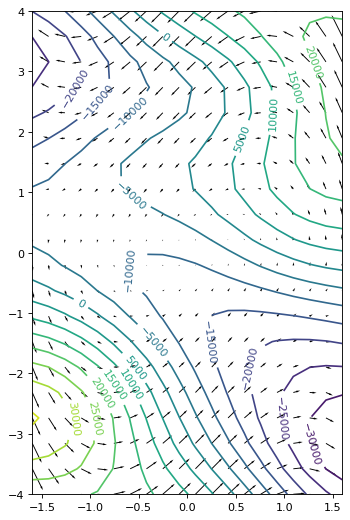

In [219]:
plt.figure(figsize=(5,8))
cp = plt.contour(x,y, trial_solution, levels=15)
plt.quiver(X,Y, new_vf[0], new_vf[1], headwidth=2, headlength=4)
plt.clabel(cp, inline=True, fontsize=10)
plt.show()

In [220]:
solution.shape

(400,)